In [2]:
!pip install -q wfdb

In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
data_path = '/kaggle/input/japanese-holter-ecg/shdb-af-a-japanese-holter-ecg-database-of-atrial-fibrillation-1.0.0'
files = os.listdir(data_path)
files = [f for f in files if f.endswith('.dat') or f.endswith('.hea') or f.endswith('.atr') or f.endswith('.qrs')]

In [3]:
files_grouped = {}
for file in files:
    number = file.split('.')[0]
    if number in files_grouped:
        files_grouped[number].append(file)
    else:
        files_grouped[number] = [file]
fs = 200

In [4]:
print(f'Number of files: {len(files_grouped)}')
files_grouped['001']

Number of files: 100


['001.atr', '001.dat', '001.hea', '001.qrs']

In [5]:
example_record = list(files_grouped.keys())[0]
record = wfdb.rdsamp(os.path.join(data_path, example_record))[0]
sig = record
print("Sampling frequency:", fs)
print("Signal shape:", sig.shape)
ann = wfdb.rdann(os.path.join(data_path, example_record), 'atr')
print("Number of annotations:", len(ann.sample))
print("Annotation types:", np.unique(ann.aux_note))

Sampling frequency: 200
Signal shape: (17220000, 2)
Number of annotations: 143768
Annotation types: ['' '(AFIB' '(N']


In [6]:
def parse_rhythm_intervals(ann, default_label='UNKNOWN'):
    """
    Parse rhythm intervals from annotation object.
    Each aux_note with a rhythm name marks the start of a new rhythm interval.
    Returns a list of tuples: (start_sample, end_sample, rhythm_label).
    """
    rhythm_indices = [i for i, aux in enumerate(ann.aux_note) if len(aux.strip()) > 0]

    intervals = []
    for i in range(len(rhythm_indices)):
        start_idx = ann.sample[rhythm_indices[i]]
        label = ann.aux_note[rhythm_indices[i]]

        if i < len(rhythm_indices) - 1:
            end_idx = ann.sample[rhythm_indices[i+1]] - 1
        else:
            end_idx = ann.sample[-1] if len(ann.sample) > 0 else start_idx

        intervals.append((start_idx, end_idx, label.strip()))
    return intervals

def segment_data_using_intervals(signal, intervals, fs, window_size=5, af_label='AFIB'):
    """
    Segment the signal into fixed-length windows and label each as AF or not AF.
    Each window is considered AF if it overlaps with any interval labeled as AF.
    """
    length = len(signal)
    win_samples = int(fs * window_size)
    segments = []
    labels = []

    start = 0
    
    while start + win_samples <= length:
        seg = signal[start:start+win_samples]
        segment_end = start + win_samples - 1
        is_af = 0
        for (int_start, int_end, int_label) in intervals:
            if int_end >= start and int_start <= segment_end: 
                if af_label in int_label:
                    is_af = 1
                    break

        segments.append(seg)
        labels.append(is_af)
        start += win_samples

    return np.array(segments), np.array(labels)

In [7]:
intervals = parse_rhythm_intervals(ann)
segments, labels = segment_data_using_intervals(sig, intervals, fs)
print("Number of segments:", len(segments))
print("Labels distribution:", np.bincount(labels))

Number of segments: 17220
Labels distribution: [7509 9711]


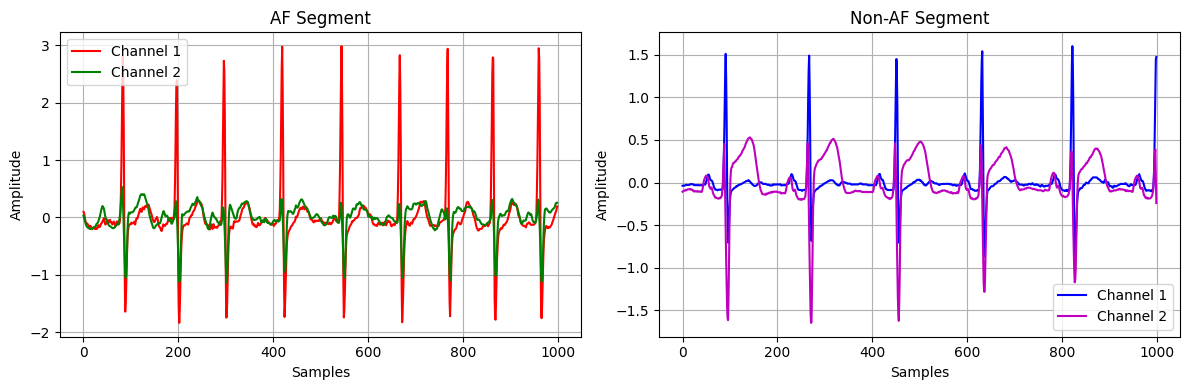

In [15]:
af_indices = np.where(labels == 1)[0]
non_af_indices = np.where(labels == 0)[0]

af_segments = segments[af_indices]
af_labels = labels[af_indices]

non_af_segments = segments[non_af_indices]
non_af_labels = labels[non_af_indices]

if af_segments.ndim == 3:
    af_segments = af_segments.squeeze()
if non_af_segments.ndim == 3:
    non_af_segments = non_af_segments.squeeze()

np.random.seed(42)
random_af_idx = np.random.randint(0, len(af_segments))
random_non_af_idx = np.random.randint(0, len(non_af_segments))

af_example = af_segments[random_af_idx]
non_af_example = non_af_segments[random_non_af_idx]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(af_example[:, 0], color='r', label='Channel 1')
axes[0].plot(af_example[:, 1], color='g', label='Channel 2')
axes[0].set_title('AF Segment')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(non_af_example[:, 0], color='b', label='Channel 1')
axes[1].plot(non_af_example[:, 1], color='m', label='Channel 2')
axes[1].set_title('Non-AF Segment')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [11]:
class AFBDataset(Dataset):
    """
    A PyTorch Dataset that:
    - Reads ECG data and annotations from given records.
    - Parses rhythm intervals from aux_note annotations.
    - Segments the signal into fixed-length windows.
    - Labels each window as AF or not AF.
    - (Optional) Normalizes the ECG segments.
    """
    def __init__(self, data_path, records, fs=200, window_size=5, af_label='AFIB', transform=None, normalize=True):
        """
        Args:
            data_path (str): Path to the directory containing record files.
            records (list): List of record names (e.g. ['100', '101', ...]).
            fs (int): Sampling frequency of the ECG signal.
            window_size (float): Window length in seconds.
            af_label (str): String that identifies AF intervals in the aux_note (e.g. 'AFIB').
            transform (callable, optional): Optional transform to be applied on a sample.
            normalize (bool): If True, normalize the data (z-score) across all segments.
        """
        self.data_path = data_path
        self.records = records
        self.fs = fs
        self.window_size = window_size
        self.af_label = af_label
        self.transform = transform
        self.normalize = normalize

        self.segments = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for rec in self.records:
            record = wfdb.rdsamp(os.path.join(self.data_path, rec))[0]
            sig = record
            ann = wfdb.rdann(os.path.join(self.data_path, rec), 'atr')
            intervals = parse_rhythm_intervals(ann)
            channel_data = sig[:, 0]
            segs, labs = segment_data_using_intervals(
                signal=channel_data,
                intervals=intervals,
                fs=self.fs,
                window_size=self.window_size,
                af_label=self.af_label
            )
            self.segments.append(segs)
            self.labels.append(labs)

        self.segments = np.concatenate(self.segments, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)

        if self.normalize:
            mean = np.mean(self.segments)
            std = np.std(self.segments) + 1e-8
            self.segments = (self.segments - mean) / std

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        x = self.segments[idx]
        y = self.labels[idx]
        
        x = np.expand_dims(x, axis=0)

        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        return x, y

In [12]:
torch.manual_seed(0)
np.random.seed(0)
train_files, test_files = train_test_split(list(files_grouped.keys()), test_size=0.15, random_state=0)
train_files, val_files = train_test_split(train_files, test_size=0.17, random_state=0)

In [13]:
print(len(train_files), len(val_files), len(test_files))

70 15 15


In [14]:
train_dataset = AFBDataset(data_path, train_files)
val_dataset = AFBDataset(data_path, val_files)
test_dataset = AFBDataset(data_path, test_files)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
for x, y in test_loader:
    print("Input shape:", x.shape)
    print(x[0, 0, :10])
    print(y)
    print("Y shape:", y.shape)
    break

In [ ]:
class Simple1DCNN(nn.Module):
    def __init__(self, input_length, num_classes=2):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm1d(32)
        
        feature_size = self._calculate_feature_size(input_length)
        self.fc = nn.Linear(feature_size, num_classes)

    def _calculate_feature_size(self, input_length):
        x = torch.zeros(1, 1, input_length)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x)))
        x = x.mean(dim=2)
        return x.shape[1]

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

In [26]:
input_length = train_dataset.segments.shape[1]
model = Simple1DCNN(input_length=input_length, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
def train_epoch(model, loader, criterion, optimizer, device='cpu'):
    model.train()
    total_loss = 0
    correct = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch(model, loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 5
best_val_acc = 0.0
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
            f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'intial_cnn.pth')

 20%|██        | 1/5 [06:28<25:53, 388.45s/it]

Epoch 1/5, Train Loss: 0.2330, Train Acc: 0.9063, Val Loss: 0.3047, Val Acc: 0.8816


 40%|████      | 2/5 [12:54<19:21, 387.17s/it]

Epoch 2/5, Train Loss: 0.1639, Train Acc: 0.9371, Val Loss: 0.2595, Val Acc: 0.9069


 60%|██████    | 3/5 [19:22<12:54, 387.28s/it]

Epoch 3/5, Train Loss: 0.1444, Train Acc: 0.9454, Val Loss: 0.2662, Val Acc: 0.8973


 80%|████████  | 4/5 [25:44<06:25, 385.31s/it]

Epoch 4/5, Train Loss: 0.1333, Train Acc: 0.9502, Val Loss: 0.5199, Val Acc: 0.8614


100%|██████████| 5/5 [32:09<00:00, 386.00s/it]

Epoch 5/5, Train Loss: 0.1263, Train Acc: 0.9533, Val Loss: 0.6360, Val Acc: 0.8425


In [3]:
def plot_losses(train_loss, valid_loss, title):
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

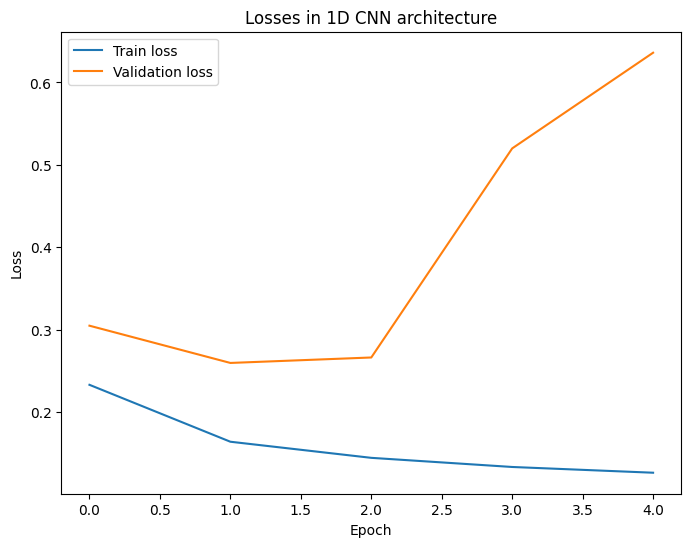

In [32]:
plot_losses(train_losses, val_losses, "Losses in 1D CNN architecture")

In [35]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            p = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(p)
            trues.extend(y.cpu().numpy())
    return total_loss / len(loader.dataset), trues, preds

In [36]:
test_loss, trues, preds = evaluate(model, test_loader, criterion)
print("Test Loss:", test_loss)
print(classification_report(trues, preds, target_names=["Non-AF", "AF"]))

Test Loss: 0.41985601309271164
              precision    recall  f1-score   support

      Non-AF       0.98      0.82      0.89    218937
          AF       0.48      0.91      0.63     40083

    accuracy                           0.83    259020
   macro avg       0.73      0.87      0.76    259020
weighted avg       0.90      0.83      0.85    259020



In [37]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=2):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*1000, num_classes)
        
    def forward(self, x):
        x = x.permute(0,2,1)
        out, _ = self.rnn(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*1000, num_classes)
        
    def forward(self, x):
        x = x.permute(0,2,1)
        out, (hn, cn) = self.lstm(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

class RawECGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(RawECGNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(32*(1000//2), num_classes)
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

class ArNet2(nn.Module):
    def __init__(self, num_classes=2):
        super(ArNet2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64*500, num_classes)
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = x.permute(0,2,1)
        out, (hn, cn) = self.lstm(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [38]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

In [45]:
def train_and_test_model(model, train_loader, val_loader, test_loader, epochs=5, loss_threshold = 0.01):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, _, _ = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        if val_loss < loss_threshold:
            break
    model.load_state_dict(best_model_state)

    test_loss, trues, preds = evaluate(model, test_loader, criterion)
    print("Test Loss:", test_loss)
    print(classification_report(trues, preds, target_names=["Non-AF", "AF"]))
    return trues, preds

In [46]:
rnn_model = SimpleRNNModel()
trues_rnn, preds_rnn = train_and_test_model(rnn_model, train_loader, val_loader, test_loader, epochs=5)

 20%|██        | 1/5 [10:13<40:54, 613.64s/it]

Epoch 1/5: Train Loss=9.0079, Val Loss=0.6975


 40%|████      | 2/5 [20:25<30:38, 612.77s/it]

Epoch 2/5: Train Loss=nan, Val Loss=nan


 60%|██████    | 3/5 [30:32<20:20, 610.20s/it]

Epoch 3/5: Train Loss=nan, Val Loss=nan


 80%|████████  | 4/5 [40:42<10:10, 610.06s/it]

Epoch 4/5: Train Loss=nan, Val Loss=nan


100%|██████████| 5/5 [50:54<00:00, 610.88s/it]

Epoch 5/5: Train Loss=nan, Val Loss=nan


Test Loss: nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Non-AF       0.85      1.00      0.92    218937
          AF       0.00      0.00      0.00     40083

    accuracy                           0.85    259020
   macro avg       0.42      0.50      0.46    259020
weighted avg       0.71      0.85      0.77    259020



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lstm_model = LSTMModel()
trues_lstm, preds_lstm = train_and_test_model(lstm_model, train_loader, val_loader, test_loader, epochs=5)

In [48]:
arnet2_model = ArNet2()
trues_, preds_arnet = train_and_test_model(arnet2_model, train_loader, val_loader, test_loader, epochs=5)

 20%|██        | 1/5 [09:09<36:39, 549.90s/it]

Epoch 1/5: Train Loss=0.1442, Val Loss=0.3743


 40%|████      | 2/5 [18:25<27:40, 553.39s/it]

Epoch 2/5: Train Loss=0.0768, Val Loss=0.3874


 60%|██████    | 3/5 [27:43<18:31, 555.55s/it]

Epoch 3/5: Train Loss=0.4078, Val Loss=1.5632


 80%|████████  | 4/5 [37:06<09:18, 558.29s/it]

Epoch 4/5: Train Loss=1.1199, Val Loss=0.8718


100%|██████████| 5/5 [46:26<00:00, 557.38s/it]

Epoch 5/5: Train Loss=0.8931, Val Loss=0.8409


Test Loss: 1.2216176706338404
              precision    recall  f1-score   support

      Non-AF       0.88      0.78      0.83    218937
          AF       0.26      0.41      0.31     40083

    accuracy                           0.73    259020
   macro avg       0.57      0.60      0.57    259020
weighted avg       0.78      0.73      0.75    259020



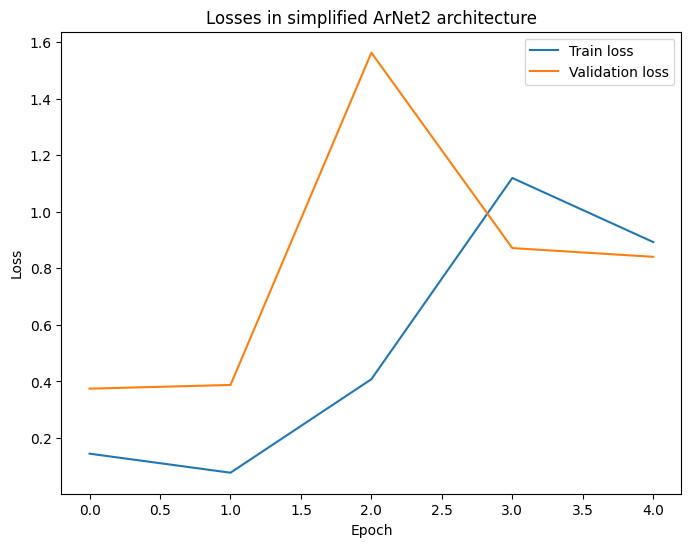

In [5]:
train_losses = [0.1442, 0.0768, 0.4078, 1.1199, 0.8931]
val_losses = [0.3743, 0.3874, 1.5632, 0.8718, 0.8409]
plot_losses(train_losses, val_losses, "Losses in simplified ArNet2 architecture")

In [18]:

class Advanced1DCNN(nn.Module):
    def __init__(self, input_length, num_classes=2, dropout_prob=0.5):
        super(Advanced1DCNN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(32, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            nn.MaxPool1d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(64, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool1d(2)
        )

        self.residual_conv = nn.Conv1d(32, 64, kernel_size=1)
        
        self.block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
        feature_size = self._calculate_feature_size(input_length)
        
        self.fc = nn.Linear(feature_size, num_classes)
        
    def _calculate_feature_size(self, input_length):
        with torch.no_grad():
            x = torch.zeros(1, 1, input_length)
            x = self.block1(x)
            x_block1 = x
            x = self.block2(x)

            x = x + self.residual_conv(x_block1[:, :, ::2])  
            x = self.block3(x)
            x = x.mean(dim=2)
            return x.shape[1]
        
    def forward(self, x):
        x_block1 = self.block1(x)
        x_block2 = self.block2(x_block1)

        x_res = self.residual_conv(x_block1[:, :, ::2])
        
        x = x_block2 + x_res
        x = self.block3(x)        
        x = x.mean(dim=2)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [17]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [57]:
input_length = train_dataset.segments.shape[1]
advanced_cnn_model = Advanced1DCNN(input_length)
model = advanced_cnn_model

In [20]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
early_stopping = EarlyStopping(patience=3, verbose=True)

In [59]:
epochs = 10
best_val_loss = float('inf')
best_model_state = None
for epoch in tqdm(range(epochs)):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * x.size(0)
    train_loss = total_train_loss / len(train_loader.dataset)

    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_val_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

model.load_state_dict(best_model_state)

 10%|█         | 1/10 [14:24<2:09:37, 864.12s/it]

Epoch 1/10, Train Loss: 0.0930, Val Loss: 0.3509


 20%|██        | 2/10 [28:51<1:55:26, 865.79s/it]

Epoch 2/10, Train Loss: 0.0728, Val Loss: 0.2655


 30%|███       | 3/10 [43:18<1:41:05, 866.46s/it]

Epoch 3/10, Train Loss: 0.0707, Val Loss: 0.3177
EarlyStopping counter: 1/3


 40%|████      | 4/10 [57:45<1:26:39, 866.65s/it]

Epoch 4/10, Train Loss: 0.0694, Val Loss: 0.4095
EarlyStopping counter: 2/3


 40%|████      | 4/10 [1:12:11<1:48:17, 1082.93s/it]

Epoch 5/10, Train Loss: 0.0685, Val Loss: 0.2666
EarlyStopping counter: 3/3
Early stopping triggered.


<All keys matched successfully>

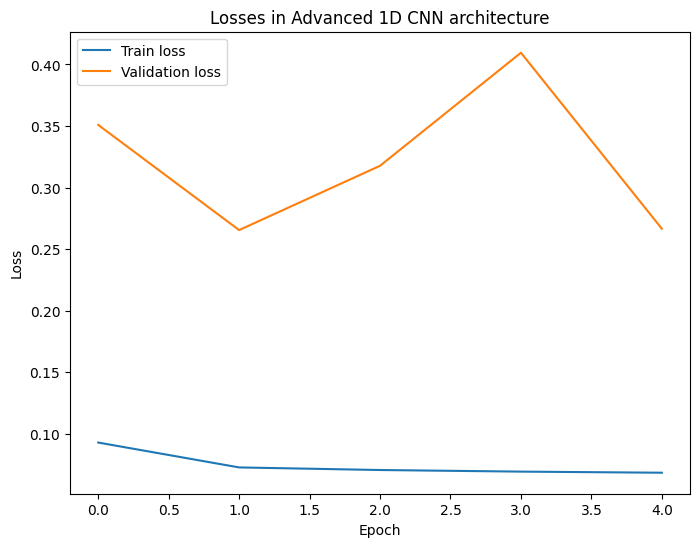

In [4]:
train_losses = [0.0930, 0.0728, 0.0707, 0.0694, 0.0685]
val_losses = [0.3509, 0.2655, 0.3177, 0.4095, 0.2666]
plot_losses(train_losses, val_losses, "Losses in Advanced 1D CNN architecture")

In [60]:
model.eval()
test_loss = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
print("Test Loss:", test_loss)
print(classification_report(all_labels, all_preds, target_names=["Non-AF","AF"]))

Test Loss: 0.1939716433744944
              precision    recall  f1-score   support

      Non-AF       0.94      0.98      0.96    218937
          AF       0.87      0.64      0.74     40083

    accuracy                           0.93    259020
   macro avg       0.90      0.81      0.85    259020
weighted avg       0.93      0.93      0.93    259020



In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('/kaggle/input/advanced_cnn_ecg/pytorch/initial/1/advanced_cnn.pth')
model.to(device)

/tmp/ipykernel_23/4220619522.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/input/advanced_cnn_ecg/pytorch/initial/1/advanced_cnn.pth')


Advanced1DCNN(
  (block1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_conv):

In [25]:
model.eval()
test_loss = 0
logits_list = []
labels_list = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        probs = torch.softmax(output, dim=1)
        
        logits_list.append(probs.cpu().numpy())
        labels_list.append(y.cpu().numpy())

probs_array = np.concatenate(logits_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

default_preds = np.argmax(probs_array, axis=1)
print("Default Threshold (0.5) Classification Report:")
print(classification_report(labels_array, default_preds, target_names=["Non-AF", "AF"]))

threshold = 0.9
adjusted_preds = (probs_array[:,1] > threshold).astype(int)

print(f"\nHigher Threshold ({threshold}) Classification Report:")
print(classification_report(labels_array, adjusted_preds, target_names=["Non-AF", "AF"]))

threshold = 0.1
adjusted_preds = (probs_array[:,1] > threshold).astype(int)

print(f"\nLower Threshold ({threshold}) Classification Report:")
print(classification_report(labels_array, adjusted_preds, target_names=["Non-AF", "AF"]))

threshold = 0.02
adjusted_preds = (probs_array[:,1] > threshold).astype(int)

print(f"\nLowest Threshold ({threshold}) Classification Report:")
print(classification_report(labels_array, adjusted_preds, target_names=["Non-AF", "AF"]))

Default Threshold (0.5) Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.94      0.98      0.96    218937
          AF       0.87      0.64      0.74     40083

    accuracy                           0.93    259020
   macro avg       0.90      0.81      0.85    259020
weighted avg       0.93      0.93      0.93    259020


Higher Threshold (0.9) Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.89      1.00      0.94    218937
          AF       0.95      0.35      0.51     40083

    accuracy                           0.90    259020
   macro avg       0.92      0.67      0.73    259020
weighted avg       0.90      0.90      0.88    259020


Lower Threshold (0.1) Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.97      0.92      0.94    218937
          AF       0.66      0.83      0.74     40083

    accuracy                           0.9